## Data Wrangling

This notebook is based on johnowhitaker's blog post found [here](https://datasciencecastnet.home.blog/2019/10/21/zindi-uberct-part-2-stepping-up/).

It will take you through some data wrangling with ```pandas``` and ```geopandas```; to create tabular data for an ```xgboost``` Machine Learning ```predicit```ion.

In [ ]:
#because we're on google colab
!pip install --upgrade pandas
!pip install --upgrade geopandas
!pip install --upgrade sklearn
!pip install --upgrade xgboost
!pip install --upgrade seaborn

In [ ]:
#load the modules that make the magic possible
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from matplotlib import pyplot
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report, auc, accuracy_score, confusion_matrix, precision_score, mean_squared_error, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
from numpy import where, mean, sqrt, argmax, arange

In [ ]:
# mount google drive as a file system
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#set path
path = Path('/content/gdrive/My Drive/Zindi_Accident')

# Load data

Look at the ```train.csv``` and  ```road_segments.zip``` from [Zindi](https://zindi.africa/competitions/uber-movement-sanral-cape-town-challenge).

In [ ]:
# have a look
data = pd.read_csv(path/'data/train.csv', 
                   parse_dates = ['Occurrence Local Date Time'])
data.head()

,EventId,Occurrence Local Date Time,Reporting Agency,Cause,Subcause,Status,longitude,latitude,road_segment_id
0,60558,2016-01-01 00:53:00,Cam,Stationary Vehicle,Vehicle On Shoulder,Closed,18.5408955032,-33.888275,S0B3CGQ
1,60559,2016-01-01 00:54:00,CAMERA,Accident,With A Fixed Object,Closed,18.9307563219,-34.140857,RYJYAPI
2,60560,2016-01-01 02:26:00,Law Enforcement,Accident,Multi Vehicle,Closed,18.5533575029,-33.959154,U3KP57C
3,60561,2016-01-01 02:56:00,CAMERA,Stationary Vehicle,Vehicle On Shoulder,Closed,18.6775561589,-33.895258,RY0TRQ8
4,60562,2016-01-01 03:40:00,CAMERA,Accident,Multi Vehicle,Closed,18.8371319682,-34.087051,8LOVJZ3


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53845 entries, 0 to 53844
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   EventId                     53845 non-null  int64         
 1   Occurrence Local Date Time  53845 non-null  datetime64[ns]
 2   Reporting Agency            52226 non-null  object        
 3   Cause                       53845 non-null  object        
 4   Subcause                    53845 non-null  object        
 5   Status                      53845 non-null  object        
 6   longitude                   53845 non-null  object        
 7   latitude                    53845 non-null  float64       
 8   road_segment_id             53845 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 3.7+ MB


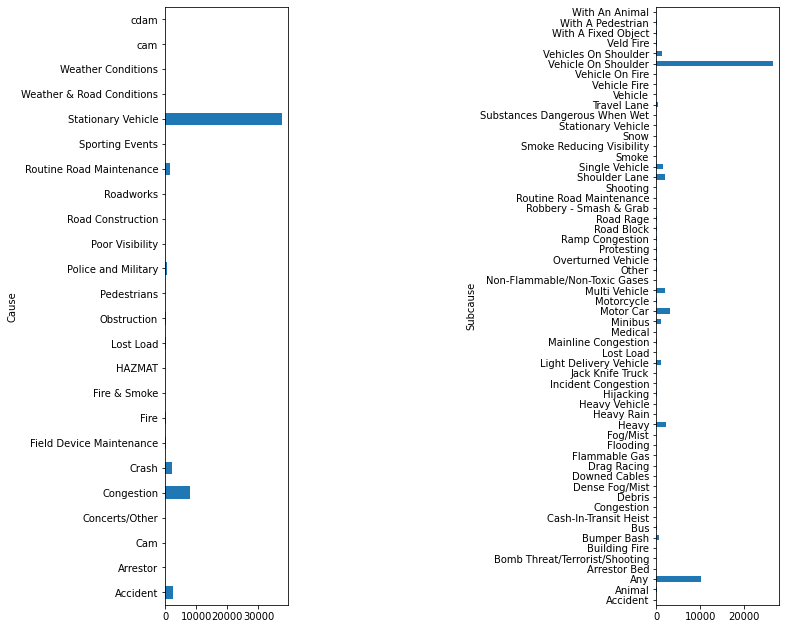

In [ ]:
# plot some metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,11)) 

cause = data.groupby('Cause').size()
ax1 = cause.plot(ax=ax1, kind = 'barh')

Subcause = data.groupby('Subcause').size()
ax2 = Subcause.plot(ax=ax2, kind = 'barh')

fig.subplots_adjust(hspace=.5, wspace=3)

plt.show()

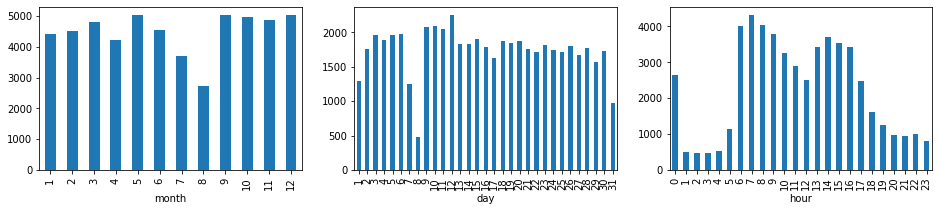

In [ ]:
# plot some more metrics
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

data['month'] = data['Occurrence Local Date Time'].dt.month
month = data.groupby('month').size()
ax1 = month.plot(ax=ax1, kind = 'bar')

data['day'] = data['Occurrence Local Date Time'].dt.day
day = data.groupby('day').size()
ax2 = day.plot(ax=ax2, kind = 'bar')

data['hour'] = data['Occurrence Local Date Time'].dt.hour
hour = data.groupby('hour').size()
ax3 = hour.plot(ax=ax3, kind = 'bar')

data.drop('month', axis=1, inplace=True)
data.drop('day', axis=1, inplace=True)
data.drop('hour', axis=1, inplace=True)
plt.show()

### I want to plot this so; convert to geopandas

In [ ]:
data["longitude"] = pd.to_numeric(data["longitude"])
data["latitude"] = pd.to_numeric(data["latitude"])

ValueError: ignored

### Why did this happen? Somethings wrong with this data.

In [ ]:
#look at the index where this happened
print(data.loc[16693])

EventId                                     88632
Occurrence Local Date Time    2016-09-12 04:45:00
Reporting Agency                              NaN
Cause                                         Cam
Subcause                                 Accident
Status                             Single Vehicle
longitude                                  Closed
latitude                                  18.5642
road_segment_id                    -33.9622761744
Name: 16693, dtype: object


#### We see that the longitude and latitude are in the wrong columns. This is  likely to have happened more than once.

In [ ]:
data.rename(columns={'Reporting Agency': 'Reporting_Agency'}, inplace=True)

In [ ]:
def transform_row(r):
    '''
    Define a function to move cells along the same row when 'Closed' appears in ['longitude']
    '''
    if r.longitude == 'Closed':
        r.Reporting_Agency = r.Cause
        r.Cause = r.Subcause
        r.Subcause = r.Status
        r.Status = r.longitude
        r.longitude = r.latitude
        r.latitude = r.road_segment_id
        r.road_segment_id = np.nan
    return r

In [ ]:
data = data.apply(transform_row, axis=1)

In [ ]:
data.isna().sum()

EventId                          0
Occurrence Local Date Time       0
Reporting_Agency              1614
Cause                            0
Subcause                         0
Status                           0
longitude                        0
latitude                         0
road_segment_id                  5
dtype: int64

It happended 5 times; but its better than deleting 1614 rows.

In [ ]:
# we don't need the Reporting Agency so leave that
data.dropna(subset=['road_segment_id'],inplace=True)

##### Lets try again

In [ ]:
data["longitude"] = pd.to_numeric(data["longitude"])
data["latitude"] = pd.to_numeric(data["latitude"])

In [ ]:
geodata = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
geodata.head()

,EventId,Occurrence Local Date Time,Reporting_Agency,Cause,Subcause,Status,longitude,latitude,road_segment_id,geometry
0,60558,2016-01-01 00:53:00,Cam,Stationary Vehicle,Vehicle On Shoulder,Closed,18.540896,-33.888275,S0B3CGQ,POINT (18.54090 -33.88827)
1,60559,2016-01-01 00:54:00,CAMERA,Accident,With A Fixed Object,Closed,18.930756,-34.140857,RYJYAPI,POINT (18.93076 -34.14086)
2,60560,2016-01-01 02:26:00,Law Enforcement,Accident,Multi Vehicle,Closed,18.553358,-33.959154,U3KP57C,POINT (18.55336 -33.95915)
3,60561,2016-01-01 02:56:00,CAMERA,Stationary Vehicle,Vehicle On Shoulder,Closed,18.677556,-33.895258,RY0TRQ8,POINT (18.67756 -33.89526)
4,60562,2016-01-01 03:40:00,CAMERA,Accident,Multi Vehicle,Closed,18.837132,-34.087051,8LOVJZ3,POINT (18.83713 -34.08705)


In [ ]:
#load the road_segments
road_segments = gpd.read_file(path/'data/road_segments.shp')

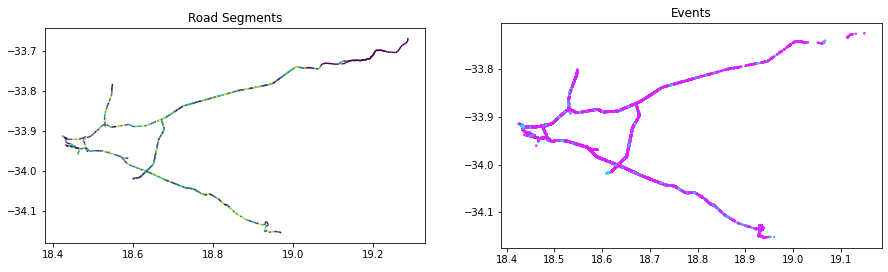

In [ ]:
# plot
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15)) 

ax1 = road_segments.plot(ax=ax1, column='segment_id', cmap='viridis')
ax1.set_title('Road Segments')

ax2 = geodata.plot(ax=ax2, marker='.', markersize = 8, column='Cause', cmap='cool')
ax2.set_title('Events')
plt.show()

In [ ]:
# harvest the mean locations of the road segments - as the competition is defined as "per 500-meter segment"
locations = data.groupby('road_segment_id').mean()[['longitude', 'latitude']]
locations.head(2)

,longitude,latitude
road_segment_id,,
03RHJ3G,18.460052,-33.943181
044ZYVD,18.555037,-33.890148


### Now we format, split the data into ```train``` and ```test``` sets and merge.


> NOTE: The challenge with tabular data is the size of the files. A years worth of accident metrics, with ancillary data such as roads and weather, in the format requested can easily create a 2GB dataframe. This will result in an ```out of memory``` crash or the inability to even save ```to_csv``` and be picked up later when the kernel is restarted. 

> To overcome this and because I'm on a shoestring budget but want to learn I'm training on a years data and testing on three months.

In [ ]:
# Train on 2017
train = data.loc[data['Occurrence Local Date Time'] < '2018-01-01']
train = train.loc[train['Occurrence Local Date Time'] >= '2017-01-01']

# Test locally on the last part of 2018
local_test = data.loc[data['Occurrence Local Date Time'] < '2019-01-01']
local_test = local_test.loc[local_test['Occurrence Local Date Time'] >= '2018-09-01']

In [ ]:
# Create a dataframe with a column for each segment_id (sid)
# Each row represents an hour.

sids = data['road_segment_id'].unique()

dts = pd.date_range('2017-01-01',
                    '2018-01-01',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    events = train.loc[train['road_segment_id'] == sid]
    dts = events['Occurrence Local Date Time'].dt.round('H')
    dates = dts.astype(str).unique()
    tr.loc[tr['datetime'].isin(dates), sid] = 1
tr.head()

,datetime,S0B3CGQ,RYJYAPI,U3KP57C,RY0TRQ8,8LOVJZ3,X4UA382,0QR8FDW,DZABHQW,EKZN1VM,H9XYX9Q,03RHJ3G,FTX7LB8,Q03FQ74,5AC6YRF,1RWEBRU,DCB3LQM,HN83F3L,SPPGKO2,C1ERJ22,AJRKP0C,UUZT4OE,WAC029P,JT4HGZ2,8Z5P9T1,UAXX1ZE,74A6FL0,2M1UBKJ,E5D3KEB,NQSL7FX,S200A1J,ETFFDX5,R6JUSZT,EDXK0HP,N5NO82G,5DHNI4S,VUYACXV,VMCY8BI,927BHUF,3MW0MN9,...,J8FAZRB,P66KAPS,CJJI1XY,K3N8ADC,SG89YSS,XYFQJ1Q,QTT8QNT,LC8FONX,WJXP54Z,GVQD9D6,64QSPWU,LRCHHQJ,Q2HCM1O,F055OA5,SY568EU,QBSA1OR,8YJIRQ2,KVOVDD8,H983665,7T2W8WU,4NSOFJG,4UAL23D,956JU5F,B8NRA4K,PH8DIYU,F47NAGJ,1NG8I9K,ZP9STNM,D3349RH,E4L0I98,YVR8GT6,ZAVM3PJ,DS4NLQE,HR19LL7,1451FOG,2ON8NSO,NFUEAN5,4T821GV,J6A19TW,43RCYZH
0,2017-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-01-01 02:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017-01-01 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Reshape this as in sample submission
# add some extra columns that may be useful
train = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c) 
                                             for c in sids] 
                                            for x in tr['datetime']]),
    'datetime':np.concatenate([[str(x) for c in sids] for x in tr['datetime']]),
    'segment_id':np.concatenate([[str(c) for c in sids] for x in tr['datetime']]),
    'y':tr[sids].values.flatten()
})
train.head()

,datetime x segment_id,datetime,segment_id,y
0,2017-01-01 00:00:00 x S0B3CGQ,2017-01-01 00:00:00,S0B3CGQ,0
1,2017-01-01 00:00:00 x RYJYAPI,2017-01-01 00:00:00,RYJYAPI,0
2,2017-01-01 00:00:00 x U3KP57C,2017-01-01 00:00:00,U3KP57C,0
3,2017-01-01 00:00:00 x RY0TRQ8,2017-01-01 00:00:00,RY0TRQ8,0
4,2017-01-01 00:00:00 x 8LOVJZ3,2017-01-01 00:00:00,8LOVJZ3,0


In [ ]:
# Same for local test
dts = pd.date_range('2018-09-01','2018-12-31',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    events = local_test.loc[local_test['road_segment_id'] == sid]
    dts = events['Occurrence Local Date Time'].dt.round('H')
    dates = dts.astype(str).unique()
    tr.loc[tr['datetime'].isin(dates), sid] = 1
    
test = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c) 
                                             for c in sids] 
                                            for x in tr['datetime']]),
    'datetime':np.concatenate([[str(x) for c in sids] for x in tr['datetime']]),
    'segment_id':np.concatenate([[str(c) for c in sids] for x in tr['datetime']]),
    'y':tr[sids].values.flatten()
})
test.head()

,datetime x segment_id,datetime,segment_id,y
0,2018-09-01 00:00:00 x S0B3CGQ,2018-09-01 00:00:00,S0B3CGQ,0
1,2018-09-01 00:00:00 x RYJYAPI,2018-09-01 00:00:00,RYJYAPI,0
2,2018-09-01 00:00:00 x U3KP57C,2018-09-01 00:00:00,U3KP57C,0
3,2018-09-01 00:00:00 x RY0TRQ8,2018-09-01 00:00:00,RY0TRQ8,0
4,2018-09-01 00:00:00 x 8LOVJZ3,2018-09-01 00:00:00,8LOVJZ3,0


In [ ]:
#add some colums
train['datetime'] = pd.to_datetime(train['datetime'])
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.weekday
train['hour'] = train['datetime'].dt.hour

In [ ]:
train.head()

,datetime x segment_id,datetime,segment_id,y,year,month,day,hour
0,2017-01-01 00:00:00 x S0B3CGQ,2017-01-01,S0B3CGQ,0,2017,1,6,0
1,2017-01-01 00:00:00 x RYJYAPI,2017-01-01,RYJYAPI,0,2017,1,6,0
2,2017-01-01 00:00:00 x U3KP57C,2017-01-01,U3KP57C,0,2017,1,6,0
3,2017-01-01 00:00:00 x RY0TRQ8,2017-01-01,RY0TRQ8,0,2017,1,6,0
4,2017-01-01 00:00:00 x 8LOVJZ3,2017-01-01,8LOVJZ3,0,2017,1,6,0


In [ ]:
#do the same for the test
test['datetime'] = pd.to_datetime(test['datetime'])
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.weekday
test['hour'] = test['datetime'].dt.hour

In [ ]:
# add some more data - roads and location

#locations
train = pd.merge(train, locations, left_on='segment_id', right_on='road_segment_id')
# road data
train = pd.merge(train, road_segments, on='segment_id', how='left')
train.head(3)

,datetime x segment_id,datetime,segment_id,y,year,month,day,hour,longitude,latitude,ROADNO,CLASS,REGION,WIDTH,LANES,SURFTYPE,PAVETYPE,CONDITION,length_1,geometry
0,2017-01-01 00:00:00 x S0B3CGQ,2017-01-01 00:00:00,S0B3CGQ,0,2017,1,6,0,18.541422,-33.888613,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8..."
1,2017-01-01 01:00:00 x S0B3CGQ,2017-01-01 01:00:00,S0B3CGQ,0,2017,1,6,1,18.541422,-33.888613,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8..."
2,2017-01-01 02:00:00 x S0B3CGQ,2017-01-01 02:00:00,S0B3CGQ,0,2017,1,6,2,18.541422,-33.888613,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8..."


In [ ]:
# Same for the test
#locations
test = pd.merge(test, locations, left_on='segment_id', right_on='road_segment_id')
# road data
test = pd.merge(test, road_segments, on='segment_id', how='left')
test.head(3)


,datetime x segment_id,datetime,segment_id,y,year,month,day,hour,longitude,latitude,ROADNO,CLASS,REGION,WIDTH,LANES,SURFTYPE,PAVETYPE,CONDITION,length_1,geometry
0,2018-09-01 00:00:00 x S0B3CGQ,2018-09-01 00:00:00,S0B3CGQ,0,2018,9,5,0,18.541422,-33.888613,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8..."
1,2018-09-01 01:00:00 x S0B3CGQ,2018-09-01 01:00:00,S0B3CGQ,0,2018,9,5,1,18.541422,-33.888613,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8..."
2,2018-09-01 02:00:00 x S0B3CGQ,2018-09-01 02:00:00,S0B3CGQ,0,2018,9,5,2,18.541422,-33.888613,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8..."


In [ ]:
#clean up
data, local_test = 0, 0

#### At this stage you can clean up the dataframe to only have the relevant columns you need or define the columns to learn with through a simple ```list```.

In [ ]:
x_cols = ['month', 'day', 'hour', 'longitude', 'latitude', 'WIDTH', 'LANES']

### Before we go any further: we need to do some more wrangling because our data is highly imbalanced.

Class 0: 4751754
Class 1: 14230


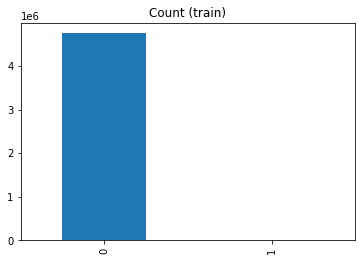

In [ ]:
# count examples in each class
train_count = train['y'].value_counts()
print('Class 0:', train_count[0])
print('Class 1:', train_count[1])
train_count.plot(kind='bar', title='Count (train)')
plt.show()

#### Why does this matter?

- lets run a quick example with the data 'as-is'.

In [ ]:
model = XGBClassifier(objective ='binary:logistic')              # set model
model.fit(train[x_cols],train['y'])                              # what do you want to train with?
preds = model.predict(train[x_cols])                             # what do you want to predict?
print(preds)                                                     # print the predictions
# Get scores                                                     # lets look at some accuracy measures
accuracy = accuracy_score(train['y'], preds)
print('Accuracy: %.2f%%' % (accuracy * 100.0))
print('')
rmse = mean_squared_error(train['y'], preds)
print("RMSE: %f" % (rmse))
f1 = f1_score(train['y'], preds)
print('f1-score: %.2f%%' % f1)

[15:36:17] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0 0 0 ... 0 0 0]
Accuracy: 99.70%

RMSE: 0.002984
f1-score: 0.00%


### Our ```accuracy``` is amazing but our ```f1-score``` is 0.

Confusion matrix:
 [[4751734      20]
 [  14204      26]]


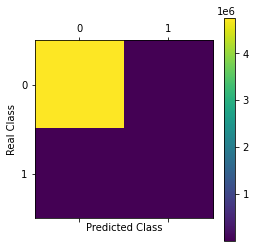

In [ ]:
# Build confusion matrix from ground truth labels and model predictions
conf_mat = confusion_matrix(y_true=train['y'], y_pred=preds)
print('Confusion matrix:\n', conf_mat)

# Plot matrix
plt.matshow(conf_mat)
plt.colorbar()
plt.ylabel('Real Class')
plt.xlabel('Predicted Class')
plt.show()

### We're ```predict```ing ```0```'s and ```1```'s equally and not enough of iether. We need to add some kind of ```weight``` so that the algorithm knows to add more emphasis to one class. Luckily we can estimate a ```scale_pos_weight```...

In [ ]:
# estimate scale_pos_weight value
estimate = train_count[0] / train_count[1]
print('Estimate (class imbalance): %.3f' % estimate)

Estimate (class imbalance): 333.925


In [ ]:
# Create the model
model = XGBClassifier(objective='binary:logistic', scale_pos_weight = 333.925)

#### ... or perform a ```grid search``` - which I could not get to work.

In [ ]:
model = XGBClassifier(objective='binary:logistic')

# define grid
param_grid = {                                                          # this list can change as we narrow the search field 
    'scale_pos_weight': [100, 300, 500]                                 # instead of overloading the processor with one long list
    }

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    n_jobs=1, cv=cv, scoring='f1')

# execute the grid search
grid_result = grid.fit(train[x_cols], train['y'])

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#### Lets continue with the estimated ```scale_pos_weight```

In [ ]:
#fit
model.fit(train[x_cols], train['y'])

[15:47:22] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=333.925, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

#### Lets find the ```most_important``` features

In [ ]:
sorted_idx = np.argsort(model.feature_importances_)[::-1]
sorted_idx


array([3, 4, 5, 2, 0, 1, 6])

In [ ]:
for index in sorted_idx:
    print([train.columns[index], model.feature_importances_[index]]) 

['y', 0.3721216]
['year', 0.18434048]
['month', 0.17943902]
['segment_id', 0.13803154]
['datetime x segment_id', 0.07750761]
['datetime', 0.048559785]
['day', 0.0]


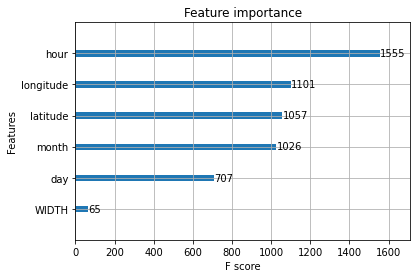

In [ ]:
plot_importance(model, max_num_features = 7)
pyplot.show()

##### ```hour``` of the day!

## Optimal Threshold for ROC Curve

> A useful tool when predicting the probability of a binary outcome is the *Receiver Operating Characteristic* curve, or ROC curve.

> It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. In other words, it plots the false alarm rate versus the hit rate - for a detailed tutorial please see [here](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/).





In [ ]:
#lets predict *PROBABILITIES*  on the training-set
y_pred_train = model.predict_proba(train[x_cols])

In [ ]:
# keep probabilities for the positive outcome only
y_pred_train = y_pred_train[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(train['y'], y_pred_train)

#same for the test
y_pred_test = model.predict_proba(test[x_cols])
y_pred_test =  y_pred_test[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(test['y'],y_pred_test)

In [ ]:
# calculate the g-mean for each threshold
#the train
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best ROC Training Threshold = %f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#the test
gmeans_t = sqrt(tpr_test * (1-fpr_test))
# locate the index of the largest g-mean
ix_t = argmax(gmeans_t)
print('Best ROC Test Threshold = %f, G-Mean=%.3f' % (thresholds_test[ix_t], gmeans_t[ix_t]))

Best ROC Training Threshold = 0.489447, G-Mean=0.837
Best ROC Test Threshold = 0.306746, G-Mean=0.719


#### Plot ROC curves for both the ```training``` and ```test``` datasets

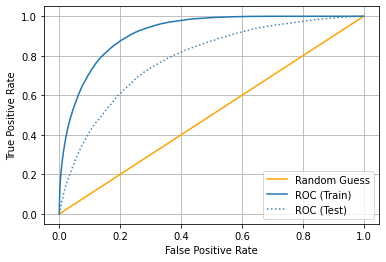

In [ ]:

fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange')#,lw=3)
plt.plot(fpr,tpr,label='ROC (Train)')#,lw=3)
plt.plot(fpr_test,tpr_test,'r:',label='ROC (Test)',color='steelblue')#,lw=3)
#pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Train')
#pyplot.scatter(fpr_test[ix_t], tpr_test[ix_t], marker='o', color='red', label='Best Test')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

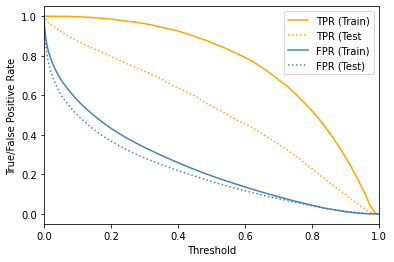

In [ ]:
plt.plot(thresholds,tpr,'r-',label='TPR (Train)',color='orange')#,lw=3)
plt.plot(thresholds_test,tpr_test,'r:',label='TPR (Test',color='orange')#,lw=3)
plt.plot(thresholds,fpr,'r-',label='FPR (Train)',color='steelblue')#,lw=3)
plt.plot(thresholds_test,fpr_test,'r:',label='FPR (Test)',color='steelblue')#,lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('True/False Positive Rate')
plt.legend()
plt.show()

## Optimal Threshold for Precision-Recall Curve




> Precision: The fraction of the time we are correct when making a positive prediction (saying there is an accident)

> Recall: The fraction of accidents we predict. 


##### We can calculate a Precision-Recall Curve with probabilities but to genereate a meaningful ```f1-score```/measure (the challenge requirement) we need to predict a class - a ```0``` or a ```1```.

In [ ]:
#for the training
# predict class values
yhat = model.predict(train[x_cols])
lr_precision, lr_recall, thresh = precision_recall_curve(train['y'], y_pred_train)
lr_f1, lr_auc = f1_score(train['y'], yhat), auc(lr_recall, lr_precision)
# summarize scores
print(' Training Classification: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

#for the test
# predict class values
yhat_t = model.predict(test[x_cols])
lr_precision_t, lr_recall_t, thresh_t = precision_recall_curve(test['y'], y_pred_test)
lr_f1_t, lr_auc_t = f1_score(test['y'], yhat_t), auc(lr_recall_t, lr_precision_t)
# summarize scores
print('Test Classification: f1=%.3f auc=%.3f' % (lr_f1_t, lr_auc_t))

 Training Classification: f1=0.026 auc=0.064
Test Classification: f1=0.035 auc=0.021


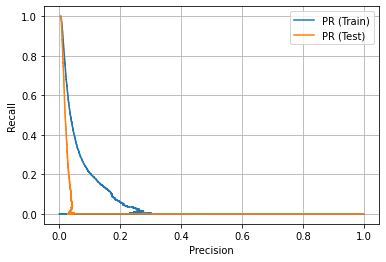

In [ ]:
fig,ax = plt.subplots()
plt.plot(lr_precision,lr_recall,label='PR (Train)')#,lw=3)
plt.plot(lr_precision_t,lr_recall_t,label='PR (Test)')#,lw=3)
#pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best Training')
#pyplot.scatter(recall_test[ix_t], precision_test[ix_t], marker='o', color='red', label='Best Test')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.legend()
plt.show()

#### The scores show that the model that looked good according to the ```ROC Curve``` is in fact not; when considering the ```precision and recall``` that focus on the positive class. The plot highlights that the model is just barely above the no skill line for most thresholds.

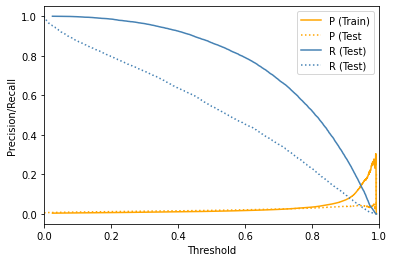

In [ ]:
plt.plot(thresh,lr_precision[:-1],'r-',label='P (Train)',color='orange')#,lw=3)
plt.plot(thresh_t,lr_precision_t[:-1],'r:',label='P (Test',color='orange')#,lw=3)
plt.plot(thresh,lr_recall[:-1],'r-',label='R (Test)',color='steelblue')#,lw=3)
plt.plot(thresh_t,lr_recall_t[:-1],'r:',label='R (Test)',color='steelblue')#,lw=3)
#plt.plot([0,1],[0,1],'k-',lw=2)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## Threshold Tuning for F1-Score



> Our ```proba```bilities are ok. Now we need to apply a ```threshold``` to maximize an ```f1-score```. Why do we care about the ```f1-score```/measure: because it is the harmonic mean between ```precision``` and ```recall```. We can search for one.



In [ ]:
# apply threshold to predictions to create labels
def to_labels(pos_preds, threshold):
  '''
  define a function to take the prediction and threshold as an argument and return an array of integers in {0, 1}
  '''
  return (pos_preds >= threshold).astype(int)

In [ ]:
# define thresholds (start, stop, step)
threshold = np.arange(0, 1, 0.002)

In [ ]:
# evaluate each threshold
scores = [f1_score(train['y'], to_labels(y_pred_train, t)) for t in threshold]

In [ ]:
# do the same for the test
scores_t = [f1_score(test['y'], to_labels(y_pred_test, t)) for t in threshold]

In [ ]:
# get best threshold
ix = argmax(scores)
ix_t = argmax(scores_t)

print('Training Threshold = %.3f, F-Score = %.5f' % (threshold[ix], scores[ix]))
print('Test Threshold = %.3f, F-Score = %.5f' % (threshold[ix_t], scores_t[ix_t]))

Training Threshold = 0.942, F-Score = 0.14315
Test Threshold = 0.882, F-Score = 0.05676


## Predicting

In [ ]:
print('Predicting on the Training-set with a Threshold of = %.3f' % 0.942)
train['pred'] = (model.predict(train[x_cols]) > 0.942).astype(int)
print(' Accuracy:',accuracy_score(train['y'],train['pred']))
#rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (mean_squared_error(train['y'],train['pred'])))
print(' f1:',f1_score(train['y'],train['pred']))
print(' Precision:',precision_score(train['y'],train['pred']))
print(' Recall:',recall_score(train['y'],train['pred']))
#y_pred_train = model.predict(train[x_cols])
print(' AUC:',roc_auc_score(train['y'],train['pred']))
print(' Ave. Precision:',average_precision_score(train['y'],train['pred']))
train.head(3)

Predicting on the Training-set with a Threshold of = 0.942
 Accuracy: 0.8074909609432176
RMSE: 0.192509
 F1: 0.026174037180718673
 Precision: 0.013287711830158687
 Recall: 0.8664792691496838
 AUC: 0.8368967893854655
 Ave. Precision: 0.0119121853284559


,datetime x segment_id,datetime,segment_id,y,year,month,day,hour,longitude,latitude,ROADNO,CLASS,REGION,WIDTH,LANES,SURFTYPE,PAVETYPE,CONDITION,length_1,geometry,pred
0,2017-01-01 00:00:00 x S0B3CGQ,2017-01-01 00:00:00,S0B3CGQ,0,2017,1,6,0,18.541422,-33.888613,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8...",0
1,2017-01-01 01:00:00 x S0B3CGQ,2017-01-01 01:00:00,S0B3CGQ,0,2017,1,6,1,18.541422,-33.888613,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8...",0
2,2017-01-01 02:00:00 x S0B3CGQ,2017-01-01 02:00:00,S0B3CGQ,0,2017,1,6,2,18.541422,-33.888613,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8...",0


In [ ]:
# Show predicted classes
print(np.unique(train['pred'], return_counts=True))

(array([0, 1]), array([3838059,  927925]))


Confusion matrix:
 [[3836159  915595]
 [   1900   12330]]


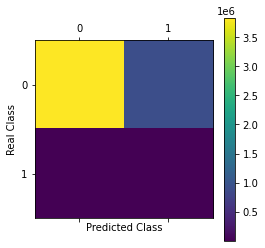

In [ ]:
# Build confusion matrix from ground truth labels and model predictions
conf_mat = confusion_matrix(y_true=train['y'], y_pred=train['pred'])
print('Confusion matrix:\n', conf_mat)

# Plot matrix
plt.matshow(conf_mat)
plt.colorbar()
plt.ylabel('Real Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
print(len(train))
good = train.loc[train['pred'] == 1]
print(len(good))

4765984
927925


In [ ]:
print(classification_report(train['y'], train['pred']))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89   4751754
           1       0.01      0.87      0.03     14230

    accuracy                           0.81   4765984
   macro avg       0.51      0.84      0.46   4765984
weighted avg       1.00      0.81      0.89   4765984



### Now the ```test```.

In [ ]:
print('Predicting on the Test-set with a Threshold of = %.3f' % 0.882)
test['pred'] = (model.predict(test[x_cols]) > 0.882).astype(int)
print (' Accuracy:',accuracy_score(test['y'],test['pred']))
#rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (mean_squared_error(test['y'], test['pred'])))
print (' f1:',f1_score(test['y'],test['pred']))
print (' Precision:',precision_score(test['y'],test['pred']))
print (' Recall:',recall_score(test['y'],test['pred']))
#y_pred_test = model.predict(test[x_cols])
print (' AUC:',roc_auc_score(test['y'],test['pred']))
print (' Ave. Precision:',average_precision_score(test['y'],test['pred']))
test.head(3)

Predicting on the Test-set with a Threshold of = 0.882
 Accuracy: 0.834124101447808
RMSE: 0.165876
 F1: 0.034589307219486685
 Precision: 0.017861557713446757
 Recall: 0.5449060106753307
 AUC: 0.690307980390188
 Ave. Precision: 0.012214646000948721


,datetime x segment_id,datetime,segment_id,y,year,month,day,hour,longitude,latitude,ROADNO,CLASS,REGION,WIDTH,LANES,SURFTYPE,PAVETYPE,CONDITION,length_1,geometry,pred
0,2018-09-01 00:00:00 x S0B3CGQ,2018-09-01 00:00:00,S0B3CGQ,0,2018,9,5,0,18.541422,-33.888613,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8...",1
1,2018-09-01 01:00:00 x S0B3CGQ,2018-09-01 01:00:00,S0B3CGQ,0,2018,9,5,1,18.541422,-33.888613,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8...",1
2,2018-09-01 02:00:00 x S0B3CGQ,2018-09-01 02:00:00,S0B3CGQ,0,2018,9,5,2,18.541422,-33.888613,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8...",1


In [ ]:
# Show predicted classes
print(np.unique(test['pred'], return_counts=True))

(array([0, 1]), array([1317409,  262911]))


Confusion matrix:
 [[1313487  258215]
 [   3922    4696]]


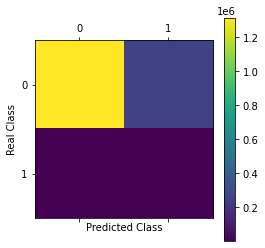

In [ ]:
# Build confusion matrix from ground truth labels and model predictions
conf_mat = confusion_matrix(y_true=test['y'], y_pred=test['pred'])
print('Confusion matrix:\n', conf_mat)

# Plot matrix
plt.matshow(conf_mat)
plt.colorbar()
plt.ylabel('Real Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
print(classification_report(test['y'], test['pred']))



              precision    recall  f1-score   support

           0       1.00      0.84      0.91   1571702
           1       0.02      0.54      0.03      8618

    accuracy                           0.83   1580320
   macro avg       0.51      0.69      0.47   1580320
weighted avg       0.99      0.83      0.90   1580320



### Save only the events to visualize

In [ ]:
print(len(test))
good = test.loc[test['pred'] == 1]
print(len(good))

1580320
262911


In [ ]:
good.head(2)

,datetime x segment_id,datetime,segment_id,y,year,month,day,hour,longitude,latitude,ROADNO,CLASS,REGION,WIDTH,LANES,SURFTYPE,PAVETYPE,CONDITION,length_1,geometry,pred
0,2018-09-01 00:00:00 x S0B3CGQ,2018-09-01 00:00:00,S0B3CGQ,0,2018,9,5,0,18.541422,-33.888613,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8...",1
1,2018-09-01 01:00:00 x S0B3CGQ,2018-09-01 01:00:00,S0B3CGQ,0,2018,9,5,1,18.541422,-33.888613,N1,Primary,Western Cape,0.0,0,Paved,Unknown,Unknown,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8...",1


In [ ]:
#save it
good[['segment_id', 'year', 'month', 'day', 'hour', 'latitude', 'longitude', 'geometry']].to_csv(path/'data/predictions.csv', 
                                                                                                 index=False)